In [1]:
from itertools import count

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

In [32]:
FIGSIZE = 10, 10
MAP_X = (45, 55)
MAP_Y = (45, 55)

# Proportions of each age/sex group 
# The numbers here are based on a large date set from Northern IL, where 
# the age classes are: young--fawns (age < 1 yr), adolescents--yearlings 
# (1 ≤ age < 2 yr), and adults (age ≥ 2)
M_YOUNG = 0.212
M_ADOLESCENT = 0.088
M_ADULT = 0.087
F_YOUNG = 0.186 
F_ADOLESCENT = 0.084
F_ADULT = 0.343
assert (M_YOUNG + M_ADOLESCENT + M_ADULT + F_YOUNG + F_ADOLESCENT 
        + F_ADULT) == 1, 'Population proportions do not sum to 1'

# Disease
# Inital proportion of population with the disease (on [0, 1]).
INIT_PREVALENCE = 0.01

# Population densities
# Whole area (in numbers per square unit in MAP_X, MAP_Y units)
DENSITY =  4.5
# For the example, this number is for Illinois Population Densities 
# (ROSEBERRY & WOOLFE (1998)) in deer/sq.km
MAX_DENSITY = 9
# For Illinois deer, Roseberry & Woolfe 1998 estimated around 16 in ideal 
# habitat; 9 is a compromise between current est of 4.5 and max of 16

# Dispersion and Migration
# Illinois Mean Dispersal Distances in km (From Nixon)
# Mean dispersal distance by sex
DISPERSAL_DIST = {'male': 40.9, 'female': 49.0}

# Probability of dispersal by sex and age class (assuming not already 
# dispersed)
DISPERSAL_PROB = {
    'male':   {'young': 0.51, 'adolescent': 0.21, 'adult': 0},
    'female': {'young': 0.50, 'adolescent': 0.21, 'adult': 0}}

# Proportion of animals migrating by age class
MIGRATION_PROB = {
    'male':   {'young': 0, 'adolescent': 0,     'adult': 0},
    'female': {'young': 0, 'adolescent': 0.196, 'adult': 0.196}}

# Mean and standard deviation for distance migrated
MIGRATION_DIST = {
    'male':   {'young':      {'mean': 0,    'sd': 0}, 
               'adolescent': {'mean': 0,    'sd': 0},
               'adult':      {'mean': 0,    'sd': 0}},
    'female': {#'young':     {'mean': 0,    'sd': 0}, 
               'young':      {'mean': 20.8, 'sd': 7.9},
               'adolescent': {'mean': 7.3,  'sd': 5.2},
               'adult':      {'mean': 0,    'sd': 0}}}

In [33]:
# Simulation Values
ITERATIONS = 10

# Colors
# Define colors to be used to plot each sex and age-class
COLORS = {'male':   {'neo':        '#00FF00', 
                     'young':      '#00FFFF',
                     'adolescent': '#5050FF', 
                     'adult':      '#000077'},
          'female': {'neo':        '#FFFF00', 
                     'young':      '#FFB3B3',
                     'adolescent': '#FF0066', 
                     'adult':      '#AA0000'}}
PLOT_SIZE = {'neo': 16,
             'young': 32,
             'adolescent': 64,
             'adult': 128}

In [44]:
class Animal:
    _ID = count(0)
    
    def __init__(self, age, sex, coords=None):
        self.ID = next(self._ID)
        self.age = age
        self.sex = sex
        self.dispersed = False if age == 'young' else True
        self.coords = coords if coords is not None else self._init_coords()
        self.disease_status = 'negative'
        self.years_infected = np.nan
        self.vital = 'alive'
        
    def _init_coords(self):
        winter = self._get_random_coords()
        summer = self._get_summer_coords(winter)
        return {'winter': winter, 'summer': summer}
        
    def _get_random_coords(self):
        return [np.random.uniform(MAP_X[0], MAP_X[1]), 
                np.random.uniform(MAP_X[0], MAP_X[1])]
    
    def _get_summer_coords(self, winter):
        if self.sex == 'male':
            return winter
        else:
            migrate_stats = MIGRATION_DIST[self.sex][self.age]
            deg_freedom = migrate_stats['mean']
            dx, dy = self._get_coord_deltas(deg_freedom)
            summer_x = winter[0] + dx
            summer_y = winter[1] + dy
            return [summer_x, summer_y]
    
    def disperse(self):
        if self.dispersed or self.age == 'adult':
            return 
        dispersal_prob = DISPERSAL_PROB[self.sex][self.age]
        ready_to_disperse = np.random.choice(
            [True, False], p=[dispersal_prob, 1 - dispersal_prob])
        if ready_to_disperse:
            deg_freedom = DISPERSAL_DIST[self.sex]
            dx, dy = self._get_coord_deltas(deg_freedom)
            self.coords['summer'][0] += dx
            self.coords['summer'][1] += dy
            migrate_stats = MIGRATION_DIST[self.sex][self.age]
            deg_freedom = migrate_stats['mean']
            dx, dy = self._get_coord_deltas(deg_freedom)
            self.coords['winter'][0] = self.coords['summer'][0] + dx
            self.coords['winter'][1] = self.coords['summer'][1] + dy            
            self.dispersed = True
                
    def _get_coord_deltas(self, deg_freedom):
        dist = (np.random.chisquare(df=deg_freedom) if deg_freedom > 0
                else 0)
        theta = np.random.uniform(0, 2*np.pi)
        dx = dist * np.cos(theta)
        dy = dist * np.sin(theta)
        return dx, dy
            
    def __str__(self):
        disease_str = self.disease_status
        if disease_str == 'positive':
            disease_str += '(%d yrs)' % (self.years_infected)
        return ('Animal %d: %s %s\n Winters at (%.4f, %.4f)\n' 
                ' Summers at (%.4f, %.4f)\n Disease %s'
                % (self.ID, self.age, self.sex, self.winter_coords[0], 
                   self.winter_coords[1], self.summer_coords[0], 
                   self.summer_coords[1], disease_str))

    def to_dataframe(self):
        return pd.DataFrame(
            {'id': self.ID,
             'age': self.age,
             'sex': self.sex,
             'x_winter': self.coords['winter'][0],
             'y_winter': self.coords['winter'][1],
             'x_summer': self.coords['summer'][0],
             'y_summer': self.coords['summer'][1],
             'disease_status': self.disease_status,
             'years_infected': self.years_infected,
             'dispersed': self.dispersed,
             'vital': self.vital},
            index=[self.ID])

In [84]:
class Population:
    def __init__(self):
        self.n_animal = int(np.round(
            (MAP_X[1] - MAP_X[0]) * (MAP_Y[1] - MAP_Y[0]) * DENSITY))
        self.demographics = self._get_initial_demographics()
        self.n_positive = (
            int(np.round(INIT_PREVALENCE) * self.n_animal) or 1)
        self.population = self._initialize_population()
        
    def _get_initial_demographics(self):
        categories = ['male_adult', 'female_adult',
                      'male_adolescent', 'female_adolescent',
                      'male_young', 'female_young']
        sex_age = [
            M_ADULT, F_ADULT, M_ADOLESCENT, F_ADOLESCENT, M_YOUNG, F_YOUNG]
        numbers = {}
        for pop, prop in zip(categories, sex_age):
            numbers[pop] = int(np.round(prop * self.n_animal))
        return numbers
    
    def _initialize_population(self):
        print('Initializing population...')
        population = []
        mother_candidates = []
        i = 0
        # Sorting assures mothers are created before young
        for age_sex, n in sorted(list(self.demographics.items())):
            sex, age = age_sex.split('_')
            for _ in range(n):
                coords = None
                if age == 'young':
                    mother_id = np.random.choice(mother_candidates)
                    #coords = population[mother_id].coords
                    mother_coords = population[mother_id].coords
                    coords = {}
                    for season in mother_coords:
                        xy = []
                        for coord in mother_coords[season]:
                            xy.append(coord)
                        coords[season] = xy
                elif sex == 'female':
                    mother_candidates.append(i)
                animal = Animal(age, sex, coords)
                population.append(animal)
                i += 1
        population = self._initialize_disease(population)
        return population
    
    def _assign_mothers(self, population, young_inds, mother_candidates):
        for i in young_inds:
            mother_id = np.random.choice(mother_candidates)
            winter_coords = population[mother_id].winter_coords
            summer_coords = population[mother_id].summer_coords
            population[i].mother_id = mother_id
            population[i].winter_coords = winter_coords
            population[i].summer_coords = summer_coords
        return population
    
    def _initialize_disease(self, population):
        disease_inds = np.random.choice(range(len(population)), 
                                        self.n_positive)
        for i in disease_inds:
            population[i].disease_status = 'positive'
            population[i].years_infected = 0
        return population
    
    def disperse(self):
        for animal in self.population:
            animal.disperse()
                        
    def to_dataframe(self):
        df = self.population[0].to_dataframe()
        for animal in self.population[1:]:
            df = df.append(animal.to_dataframe())
        return df
    
    def plot(self, season, limits=None):
        df = self.to_dataframe()
        plt.figure(figsize=FIGSIZE)
        for sex in ['female', 'male']:
            for age in ['adult', 'adolescent', 'young']:
                plt.scatter(
                    df.loc[((df.sex == sex) & (df.age == age)), 
                           'x_%s' % season], 
                    df.loc[((df.sex == sex) & (df.age == age)), 
                           'y_%s' % season],
                    color=COLORS[sex][age],
                    s=PLOT_SIZE[age],
                    alpha=0.8,
                    label='%s %s' % (age, sex))
        plt.scatter(df.loc[df.disease_status == 'positive', 
                           'x_%s' % season],
                    df.loc[df.disease_status == 'positive', 
                           'y_%s' % season],
                    marker='+',
                    color='k',
                    s=128,
                    label='disease positive')
        if limits:
            plt.xlim(limits['x'])
            plt.ylim(limits['y'])
        plt.legend();    

Initializing population...


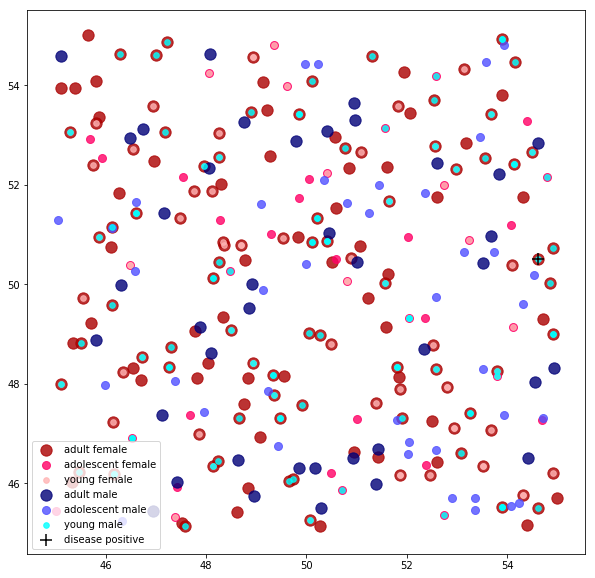

In [85]:
season = 'winter'
population = Population()
population.plot(season)

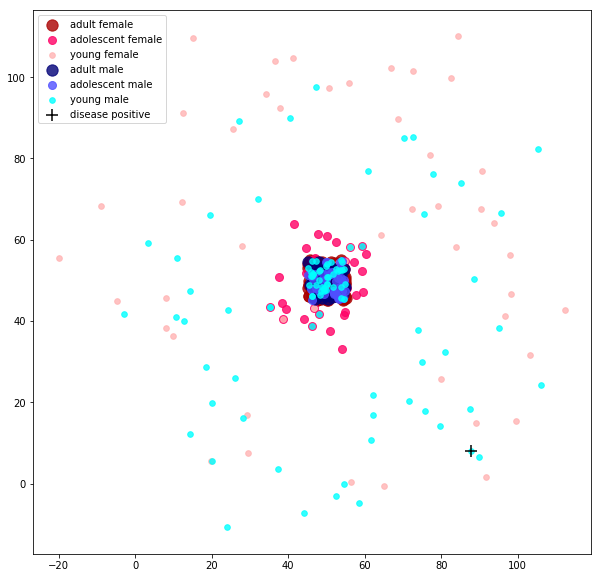

In [86]:
season = 'summer'
population.disperse()
population.plot(season)